## 4. Model Evaluation


 In machine learning, model evaluation is referred to as the process where a trained model is
 evaluated with a testing data set. The testing data set is a separate portion of the same data
 set from which the training set is derived. The main purpose of using the testing data set is to
 test the generalization ability of a trained model ([Alpaydin 2010](http://scholar.google.com/scholar_lookup?title=Introduction%20to%20machine%20learning&author=E.%20Alpaydin&publication_year=2010)).
 
 The outline of the model building and evaluation process is given below.
 <img src="../img/4/model_evaluation_process.PNG" width=400>

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, TimeSeriesSplit
from sklearn.metrics import average_precision_score, accuracy_score, precision_recall_curve

# data are stored here
data_folder = '../datasets'

# integer for the random seed
THE_ANSWER = 42

In [2]:
# load data
data = np.load('%s/data.npz' % data_folder)

# extract training data
X_train, y_train = data['X_train'], data['y_train']
# Extract testing data
X_test, y_test = data['X_test'], data['y_test']

### Training / Testing dataset

The most important thing you can do to properly evaluate your model is to not train the model on the entire dataset.

You can easily split the data into training and testing sub-sets of data using a standard train_test_split function from sklearn:

#### sklearn.model_selection.train_test_split(*arrays, **options)

In our dataset, the data is already divided into the training and testing subsets.

[Source](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

![train/test](../img/4/img2.png)

[source](https://www.experfy.com/blog/train-test-split-and-cross-validation-in-python/)

In [3]:
#Let's have a look at the first datapoint
print("The first datapoint contains the following features: ")
print("\n")
print(X_train[0])
print("\n")
print("The number of data points in the training dataset is " + str(y_train.size))
print("\n")
print("The number of data points in the testing dataset is  " + str(y_test.size))

The first datapoint contains the following features: 


[ 0.6156176  -0.78584207  0.56566955  0.60753437 -0.17992427 -0.32535287
 -0.32719857 -0.32719857 -0.15201037  0.18929607  0.21877548         nan
 -1.564559           nan  1.87409565  0.3909332  -1.64262716 -0.33748312
  1.64262716         nan         nan  0.90230299         nan         nan
  1.37062409 -0.00604467 -0.01317495 -0.76401196  0.93544524 -0.04058151
 -0.17166864 -0.02962516 -0.26744559]


The number of data points in the training dataset is 65579


The number of data points in the testing dataset is  22034


In [4]:
# let's take a look at the class labels stored in the y_train array
print(y_train)
print('The class == 1 rows make %0.f%% of the data set.' % (100*y_train.sum()/y_train.size))

[0. 1. 1. ... 0. 0. 0.]
The class == 1 rows make 34% of the data set.


#### Only 34% of rows are of class 1 --> the data set is imbalanced.

Let's start with training a classifier on the training set and then testing its performance on the testing dataset.

In [5]:
# instantiate the RandomForestClassifier
model = RandomForestClassifier()

# print out the default values of model hyper-parameters (will talk about hyper-parameters later)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [6]:
# set the number of trees to 500, and the random seed to THE_ANSWER for reproducibility
model.set_params(n_estimators=500, random_state=THE_ANSWER)
#model = RandomForestClassifier(n_estimators=500, random_state=THE_ANSWER) # another way of doing it

# check that the model changed
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [7]:
# some values in the training set are NaN (i.e., are missing).
# The Random Forest classifier does not like that, so we set NaN values to 10000.
X_train_fixed = X_train.copy()
X_train_fixed[np.isnan(X_train_fixed)] = 10000

#Repeat the same transformation for the testing dataset
# first, if there are NaNs in the test set, set them to 10000.
X_test_fixed = X_test.copy()
X_test_fixed[np.isnan(X_test)] = 10000

In [8]:
%%time

# fit the model using training data
model.fit(X_train_fixed, y_train)

Wall time: 1min 3s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Now that we have fit the model, we need to evaluate its performance.
That can be done using various metrics, but the simplest one is accuracy. Accuracy is defined as the percentage of correct predictions for the test data.

### accuracy = number of correct predictions / number of all predictions

In [9]:
# push the test data set through the model to get the predicted classes
y_scores = model.predict(X_test_fixed)

# the model predicts the class.
print('Predicted class:', y_scores)
print('True class:     ', y_test)

Predicted class: [0. 0. 0. ... 1. 0. 0.]
True class:      [1. 0. 0. ... 1. 0. 1.]


In [10]:
# calculate the accuracy
print('The accuracy is %.3f.' % accuracy_score(y_test, y_scores))

The accuracy is 0.892.


Great result, right? May not be since we have an imbalanced data set.
Here's an extreme example: Imagine a data set where 90% of rows are of class 0.
A naive classifier that predicts 0 for all rows will have an accuracy of 90%!


What most business people would like to know is the following:

#### 1. What is the detection rate? Did we correctly identify 50%, 80%, or more of all class 1 objects (e.g., instructions that will fail to settle)?
#### 2. What is the false alarm rate? What percentage of those tagged as class 1 are *not* class 1?

The detection rate is called "recall" in machine learning,
and the false alarm rate is related to "precision" (actually, it is 1-precision)

In [11]:
# GENIA: use graphics on this page to explain the confusion matrix, precision, and recall
# https://www.jeremyjordan.me/evaluating-a-machine-learning-model/

### Overview of Classification metrics
When performing classification predictions, there's four types of outcomes that could occur.

#### True positives
are when you predict an observation belongs to a class and it actually does belong to that class.
#### True negatives
are when you predict an observation does not belong to a class and it actually does not belong to that class.
#### False positives
occur when you predict an observation belongs to a class when in reality it does not.
#### False negatives
occur when you predict an observation does not belong to a class when in fact it does.

### Confusion Matrix

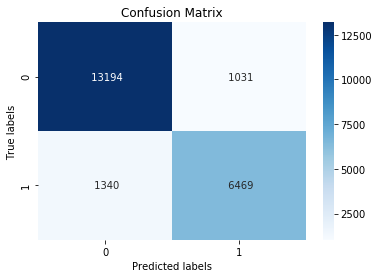

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt    
from sklearn.metrics import confusion_matrix

labels = [1, 0]
cm = confusion_matrix(y_test, y_scores)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt=' ', cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
#ax.xaxis.set_ticklabels([1, 0]); ax.yaxis.set_ticklabels([1,0])

In [15]:
TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]

print("True  Positives = %i" % TP)
print("True  Negatives = %i" % TN)
print("False Positives = %i" % FP)
print("False Negatives = %i" % FN)

True  Positives = 6469
True  Negatives = 13194
False Positives = 1031
False Negatives = 1340


### Accuracy
is defined as the percentage of correct predictions. It can be calculated easily by dividing the number of correct predictions by the number of total predictions.

![image](../img/4/img3.png)

### Precision 
is defined as the fraction of relevant examples (true positives) among all of the examples which were predicted to belong in a certain class.

![image](../img/4/img4.png)

### Recall 
is defined as the fraction of examples which were predicted to belong to a class with respect to all of the examples that truly belong in the class.

![image](../img/4/img5.png)

[Source](https://www.jeremyjordan.me/evaluating-a-machine-learning-model/)

![image](../img/4/img7.png)

[Source](https://www.jeremyjordan.me/evaluating-a-machine-learning-model/)

Precision and recall are useful in cases where classes aren't evenly distributed. The common example is for developing a classification algorithm that predicts whether or not someone has a disease. If only a small percentage of the population (let's say 1%) has this disease, we could build a classifier that always predicts that the person does not have the disease, we would have built a model which is 99% accurate and 0% useful. However, if we measured the recall of this useless predictor, it would be clear that there was something wrong with our model.

A common approach for combining the precision and recall metrics is known as the f-score:

![image](../img/4/img8.png)

where beta is often set to 1

![image](../img/4/img10.png)

[Source](https://www.jeremyjordan.me/evaluating-a-machine-learning-model/)

In [16]:
#Let's look at accuracy, precision and recall of our trained classifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_scores)
print("The accuracy  is %.2f" % np.round(100*accuracy, 2))

precision = precision_score(y_test, y_scores)
print("The precision is %.2f" % np.round(100*precision, 2))

recall = recall_score(y_test, y_scores)
print("The recall    is %.2f" % np.round(100*recall, 2))

f1 = f1_score(y_test, y_scores)
print("The F1        is %.2f" % np.round(100*f1, 2))

The accuracy  is 89.24
The precision is 86.25
The recall    is 82.84
The F1        is 84.51


In [17]:
# push the test data set through the model to get the classification *scores* (not labels)
# (note that we use the "predict_proba" method and not "predict")
y_proba = model.predict_proba(X_test_fixed)

# the model calculates the score for both classes (0 and 1). Each row sums to 1.
print(y_proba)
print('The y_scores is a 2-dimensional array:', y_proba.shape)

[[0.88866667 0.11133333]
 [0.828      0.172     ]
 [0.85693333 0.14306667]
 ...
 [0.378      0.622     ]
 [0.584      0.416     ]
 [0.804      0.196     ]]
The y_scores is a 2-dimensional array: (22034, 2)


In [18]:
# calculate the area under the precision-recall curve for the "positive" class
# by feeding the true class label (y_test) and the predicted classification scores (y_scores[:, 1])
print('The area under the Precision-Recall curve is %.3f.' % average_precision_score(y_test, y_proba[:, 1]))

The area under the Precision-Recall curve is 0.923.


In [19]:
# different metrics for evaluating classification models can be found here:
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [20]:
X_valid, y_valid = data['X_valid'], data['y_valid']
X_devel, y_devel = data['X_devel'], data['y_devel']
X_test, y_test = data['X_test'], data['y_test']

### Cross-Validation ???